In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [ ]:
##########################
### SETTINGS
##########################

# Device
#CUDA_DEVICE_NUM = 3
#DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cpu


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [ ]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


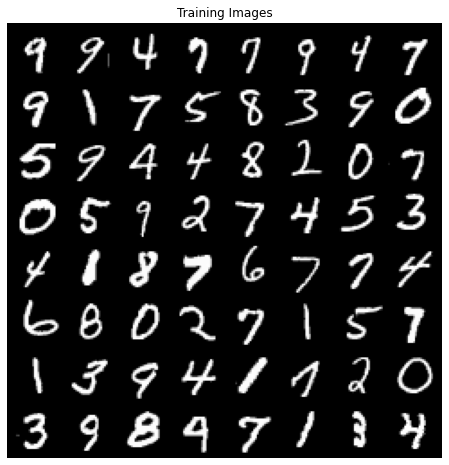

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

In [ ]:
##########################
### MODEL
##########################
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, image_height*image_width*color_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            Reshape(-1, color_channels, image_height, image_width),
            # 28, 28
            nn.Conv2d(1, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
            # (n - k + 2p) / s + 1
            # (28 - 3 + 2) / 2 + 1
            # 27 / 2 + 1 -> 14
            nn.LeakyReLU(0.01),
            nn.Conv2d(16, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
            # (n - k + 2p) / s + 1
            # (14 - 3 + 2) / 2 + 1
            # 13 / 2 + 1 -> 7
            nn.LeakyReLU(0.01),
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, image_height*image_width*color_channels),
            nn.Tanh()
        )


        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, color_channels * 28 * 28 ),
            nn.LeakyReLU(inplace=True),
            Reshape(-1, color_channels, 28 , 28 ),
            nn.Conv2d(1, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
            # 28 * 2 - 3 + 2 / 2 + 1 => 14
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            # Reshape(-1, color_channels, 14, 14),
            # nn.Conv2d(16, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
            # (n - k + 2p) / s + 1
            # 28 - 3 + 2 / 2 + 1 => 14
            # nn.LeakyReLU(inplace=True),
            # nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(16 * 14 * 14, 1), # outputs logits
            #nn.Sigmoid()
        )

    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1)
        # print(1)
        # print(z.shape)
        img = self.generator(z)
        # print(2, img.size())
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        # print(3)
        return img

    def discriminator_forward(self, img):
        # print(img.size())
        logits = self.discriminator(img)
        # print("logits",logits.size())
        return logits

In [ ]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [ ]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/020 | Batch 000/469 | Gen/Dis Loss: 0.7149/0.6699
Epoch: 001/020 | Batch 100/469 | Gen/Dis Loss: 1.2215/0.4355
Epoch: 001/020 | Batch 200/469 | Gen/Dis Loss: 2.4558/0.1208
Epoch: 001/020 | Batch 300/469 | Gen/Dis Loss: 5.0889/0.0220
Epoch: 001/020 | Batch 400/469 | Gen/Dis Loss: 2.7206/0.1297
Time elapsed: 0.74 min
Epoch: 002/020 | Batch 000/469 | Gen/Dis Loss: 2.6444/0.2099
Epoch: 002/020 | Batch 100/469 | Gen/Dis Loss: 2.6097/0.1711
Epoch: 002/020 | Batch 200/469 | Gen/Dis Loss: 2.3848/0.1755


In [ ]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

In [ ]:
##########################
### VISUALIZATION
##########################

# for i in range(0, NUM_EPOCHS, 5):
for i in range(0,NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()